# Three robust linear regression models for dealing with outliers

## Setup

In [4]:
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install sklearn

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 31.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.1/38.1 MB 27.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 38.3 MB/s eta 0:00:00
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1304 sha256=2833d39b47dc70ec2c25d2ef0103322e6a7b519ac5001bd5228e25478dccd566
  Stored in directory: /home/jovyan/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.linear_model import (LinearRegression, HuberRegressor, RANSACRegressor, TheilSenRegressor)

sns.set_theme(context="talk", style="whitegrid", 
              palette="tab10", color_codes=True, 
              rc={"figure.figsize": [20, 10]})

In [6]:
%config InlineBackend.figure_format = "retina"

## Generating data

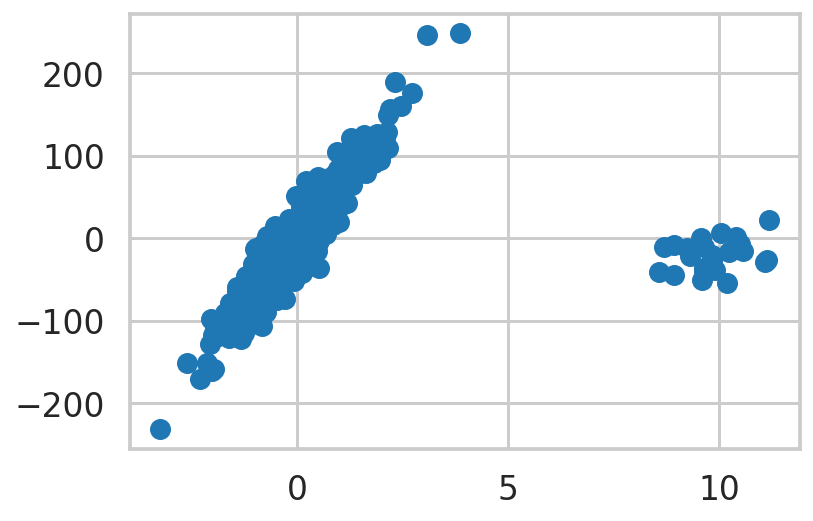

In [7]:
N_SAMPLES = 500
N_OUTLIERS = 25

X, y, coef = datasets.make_regression(
    n_samples=N_SAMPLES, 
    n_features=1, 
    n_informative=1, 
    noise=20, 
    coef=True, 
    random_state=42
)

coef_list = [["original_coef", float(coef)]]

# add outliers               
np.random.seed(42)
X[:N_OUTLIERS] = 10 + 0.75 * np.random.normal(size=(N_OUTLIERS, 1))
y[:N_OUTLIERS] = -15 + 20 * np.random.normal(size=N_OUTLIERS)

plt.scatter(X, y);

In [11]:
# sanity check - see what the coefficient would be when fitted to data without outliers
lr = LinearRegression().fit(X[N_OUTLIERS:], y[N_OUTLIERS:])
lr.coef_[0]

63.3572430951796

## Linear regression

In [13]:
lr = LinearRegression().fit(X, y)
coef_list.append(["linear_regression", lr.coef_[0]])

In [14]:
plotline_X = np.arange(X.min(), X.max()).reshape(-1, 1)

fit_df = pd.DataFrame(
    index = plotline_X.flatten(),
    data={"linear_regression": lr.predict(plotline_X)}
)

fit_df

,linear_regression
-3.241267,-34.417132
-2.241267,-25.644817
-1.241267,-16.872502
-0.241267,-8.100187
0.758733,0.672128
1.758733,9.444443
2.758733,18.216758
3.758733,26.989073
4.758733,35.761388
5.758733,44.533703


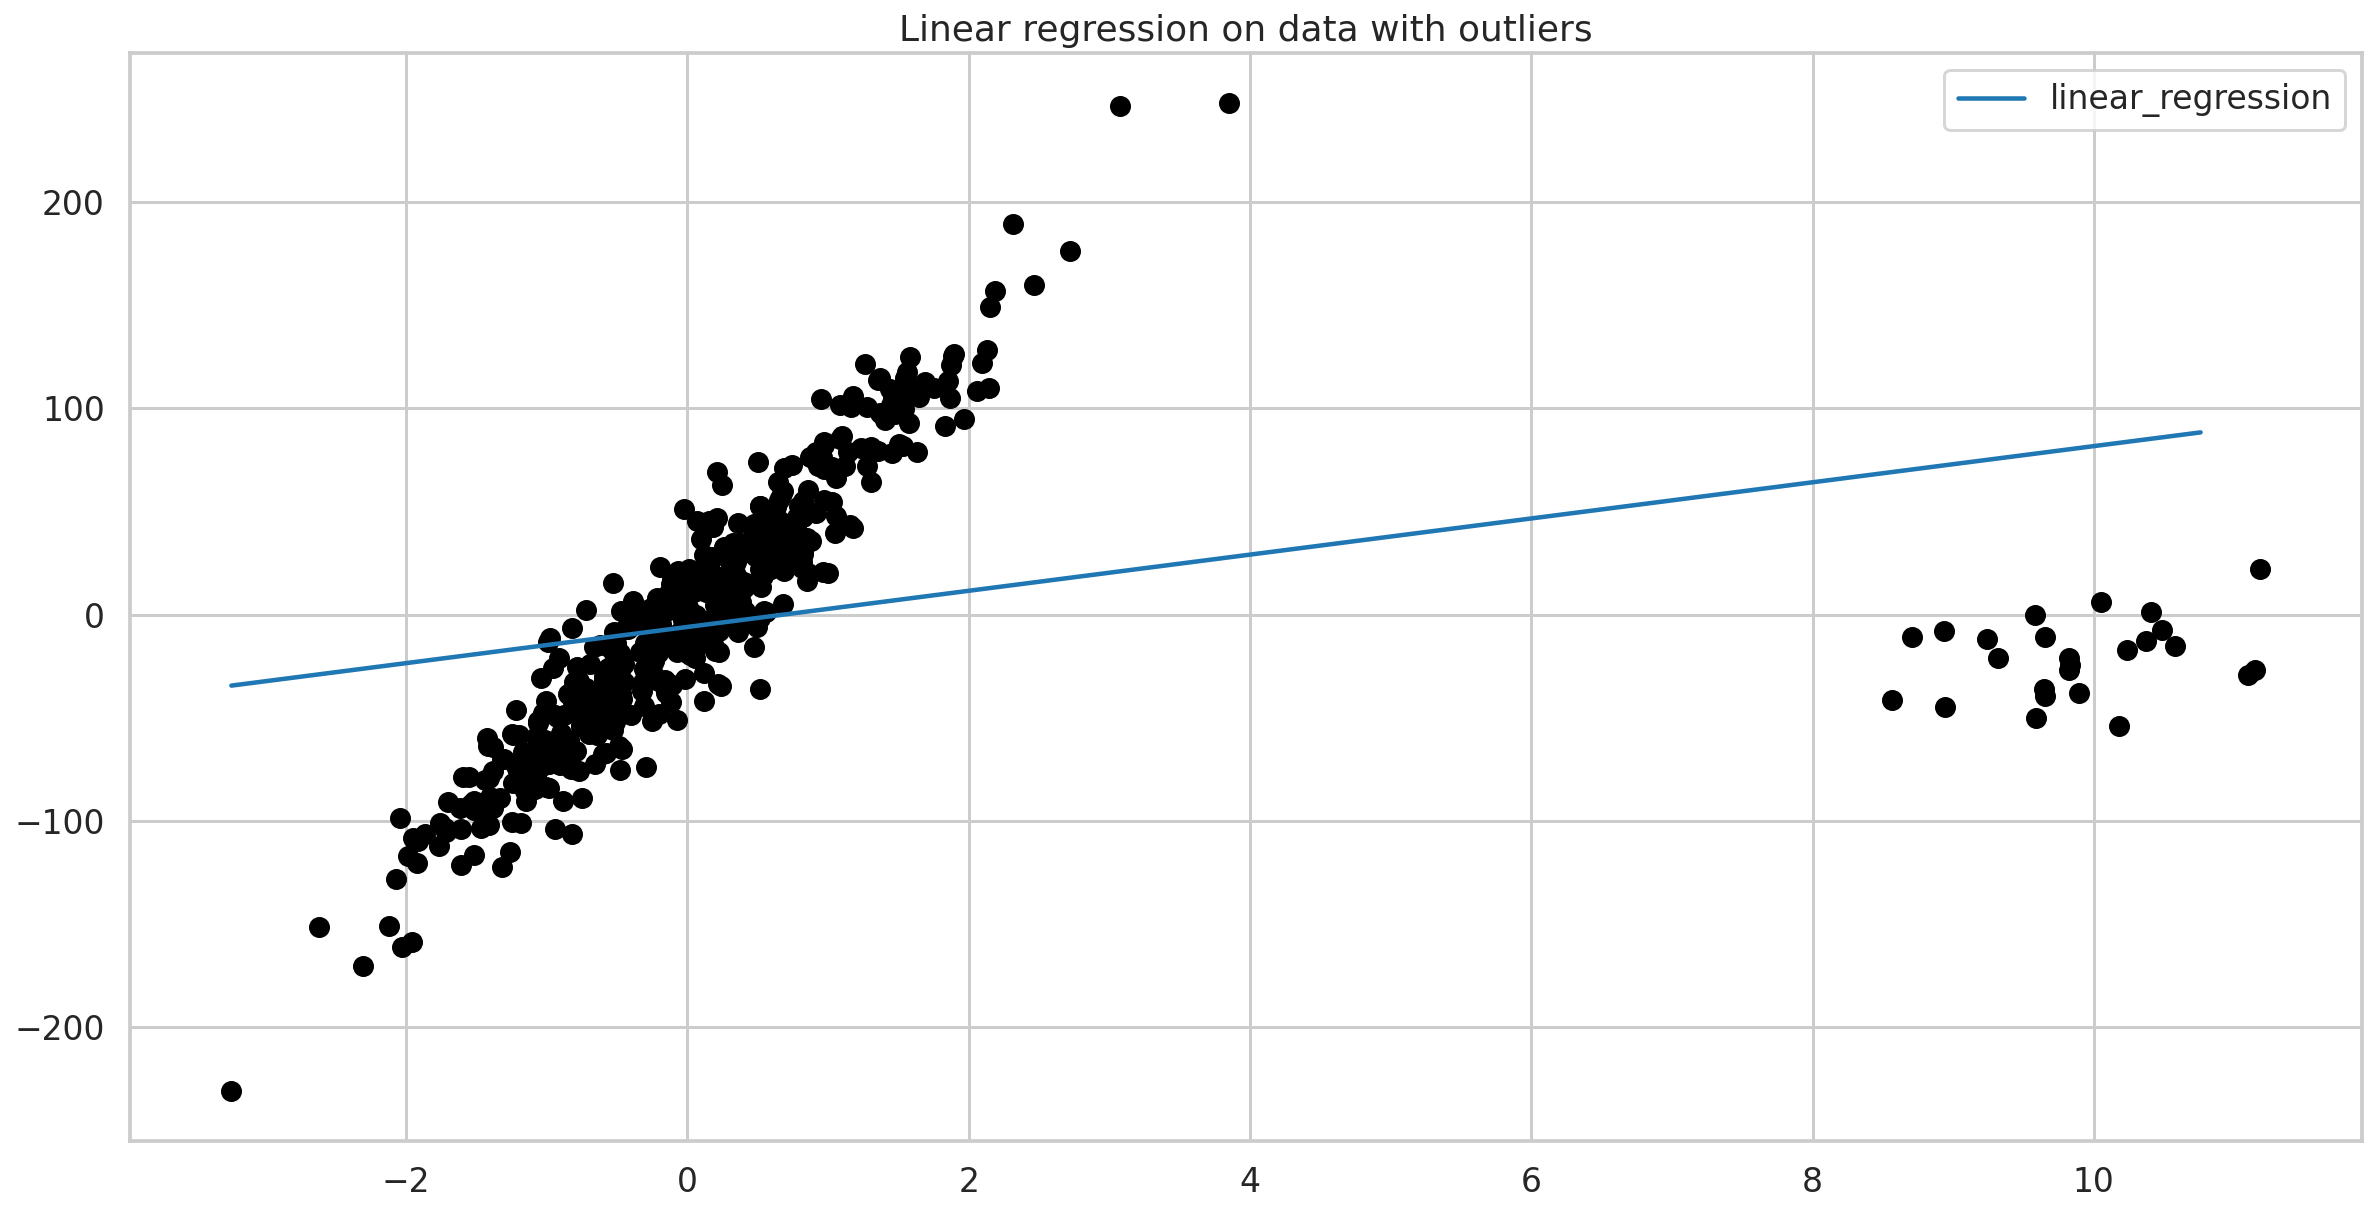

In [18]:
fix, ax = plt.subplots()
fit_df.plot(ax=ax)
plt.scatter(X, y, c="k")
plt.title("Linear regression on data with outliers");

## Huber Regression

In [19]:
huber = HuberRegressor().fit(X, y)
fit_df["huber_regression"] = huber.predict(plotline_X)
coef_list.append(["huber_regression", huber.coef_[0]])

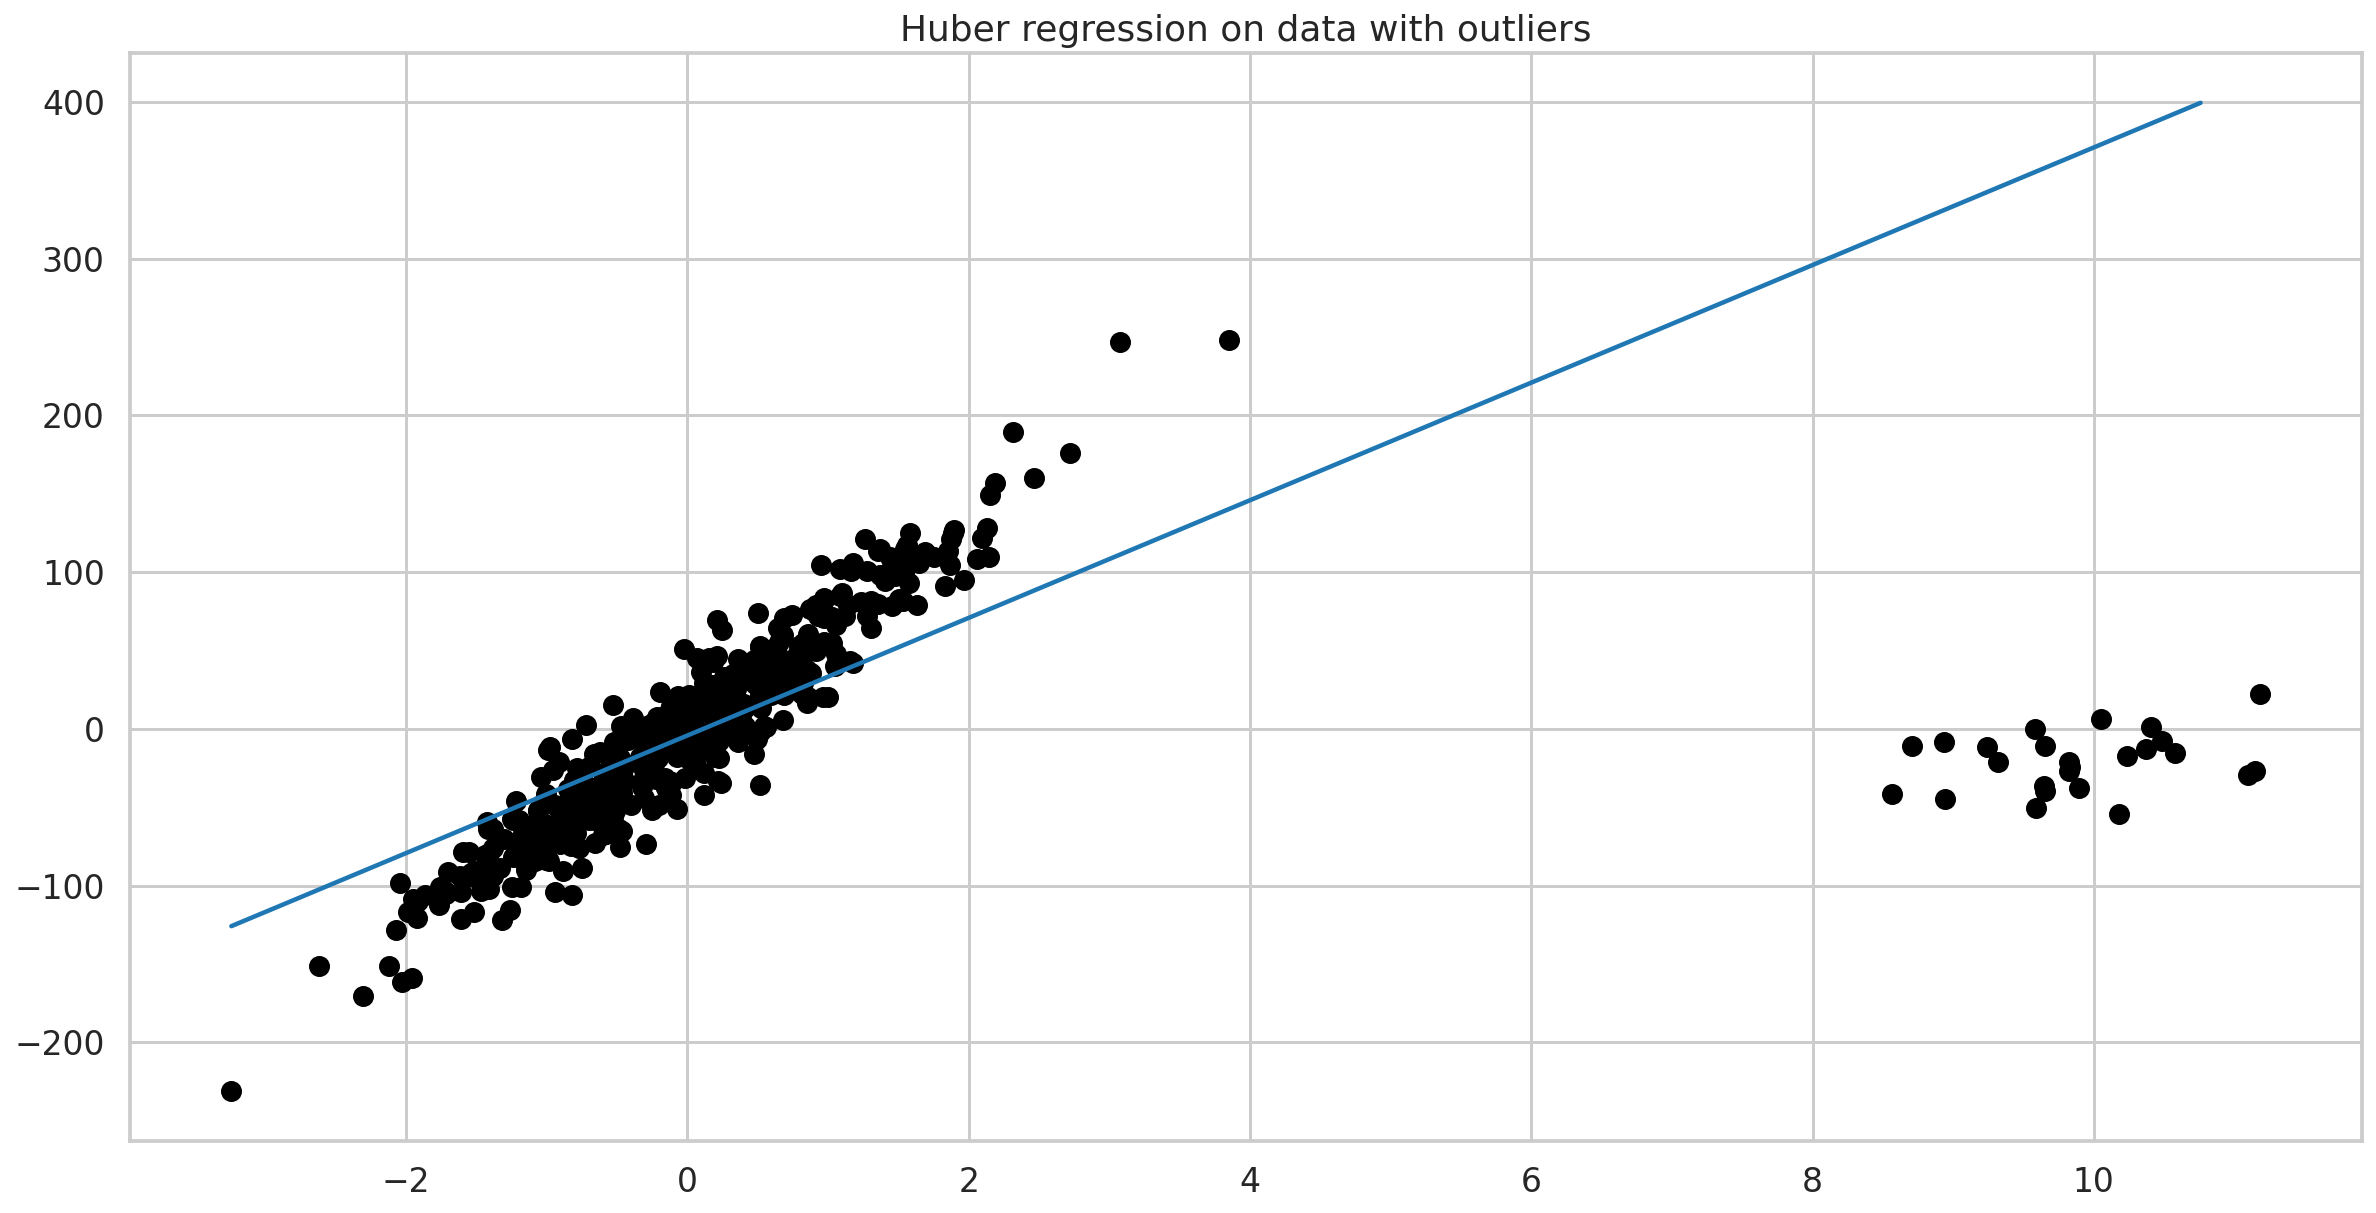

In [20]:
fix, ax = plt.subplots()
fit_df["huber_regression"].plot(ax=ax)
plt.scatter(X, y, c="k")
plt.title("Huber regression on data with outliers");

## RANSAC Regression

In [21]:
ransac = RANSACRegressor(random_state=42).fit(X, y)
fit_df["ransac_regression"] = ransac.predict(plotline_X)
ransac_coef = ransac.estimator_.coef_
coef_list.append(["ransac_regression", ransac.estimator_.coef_[0]])

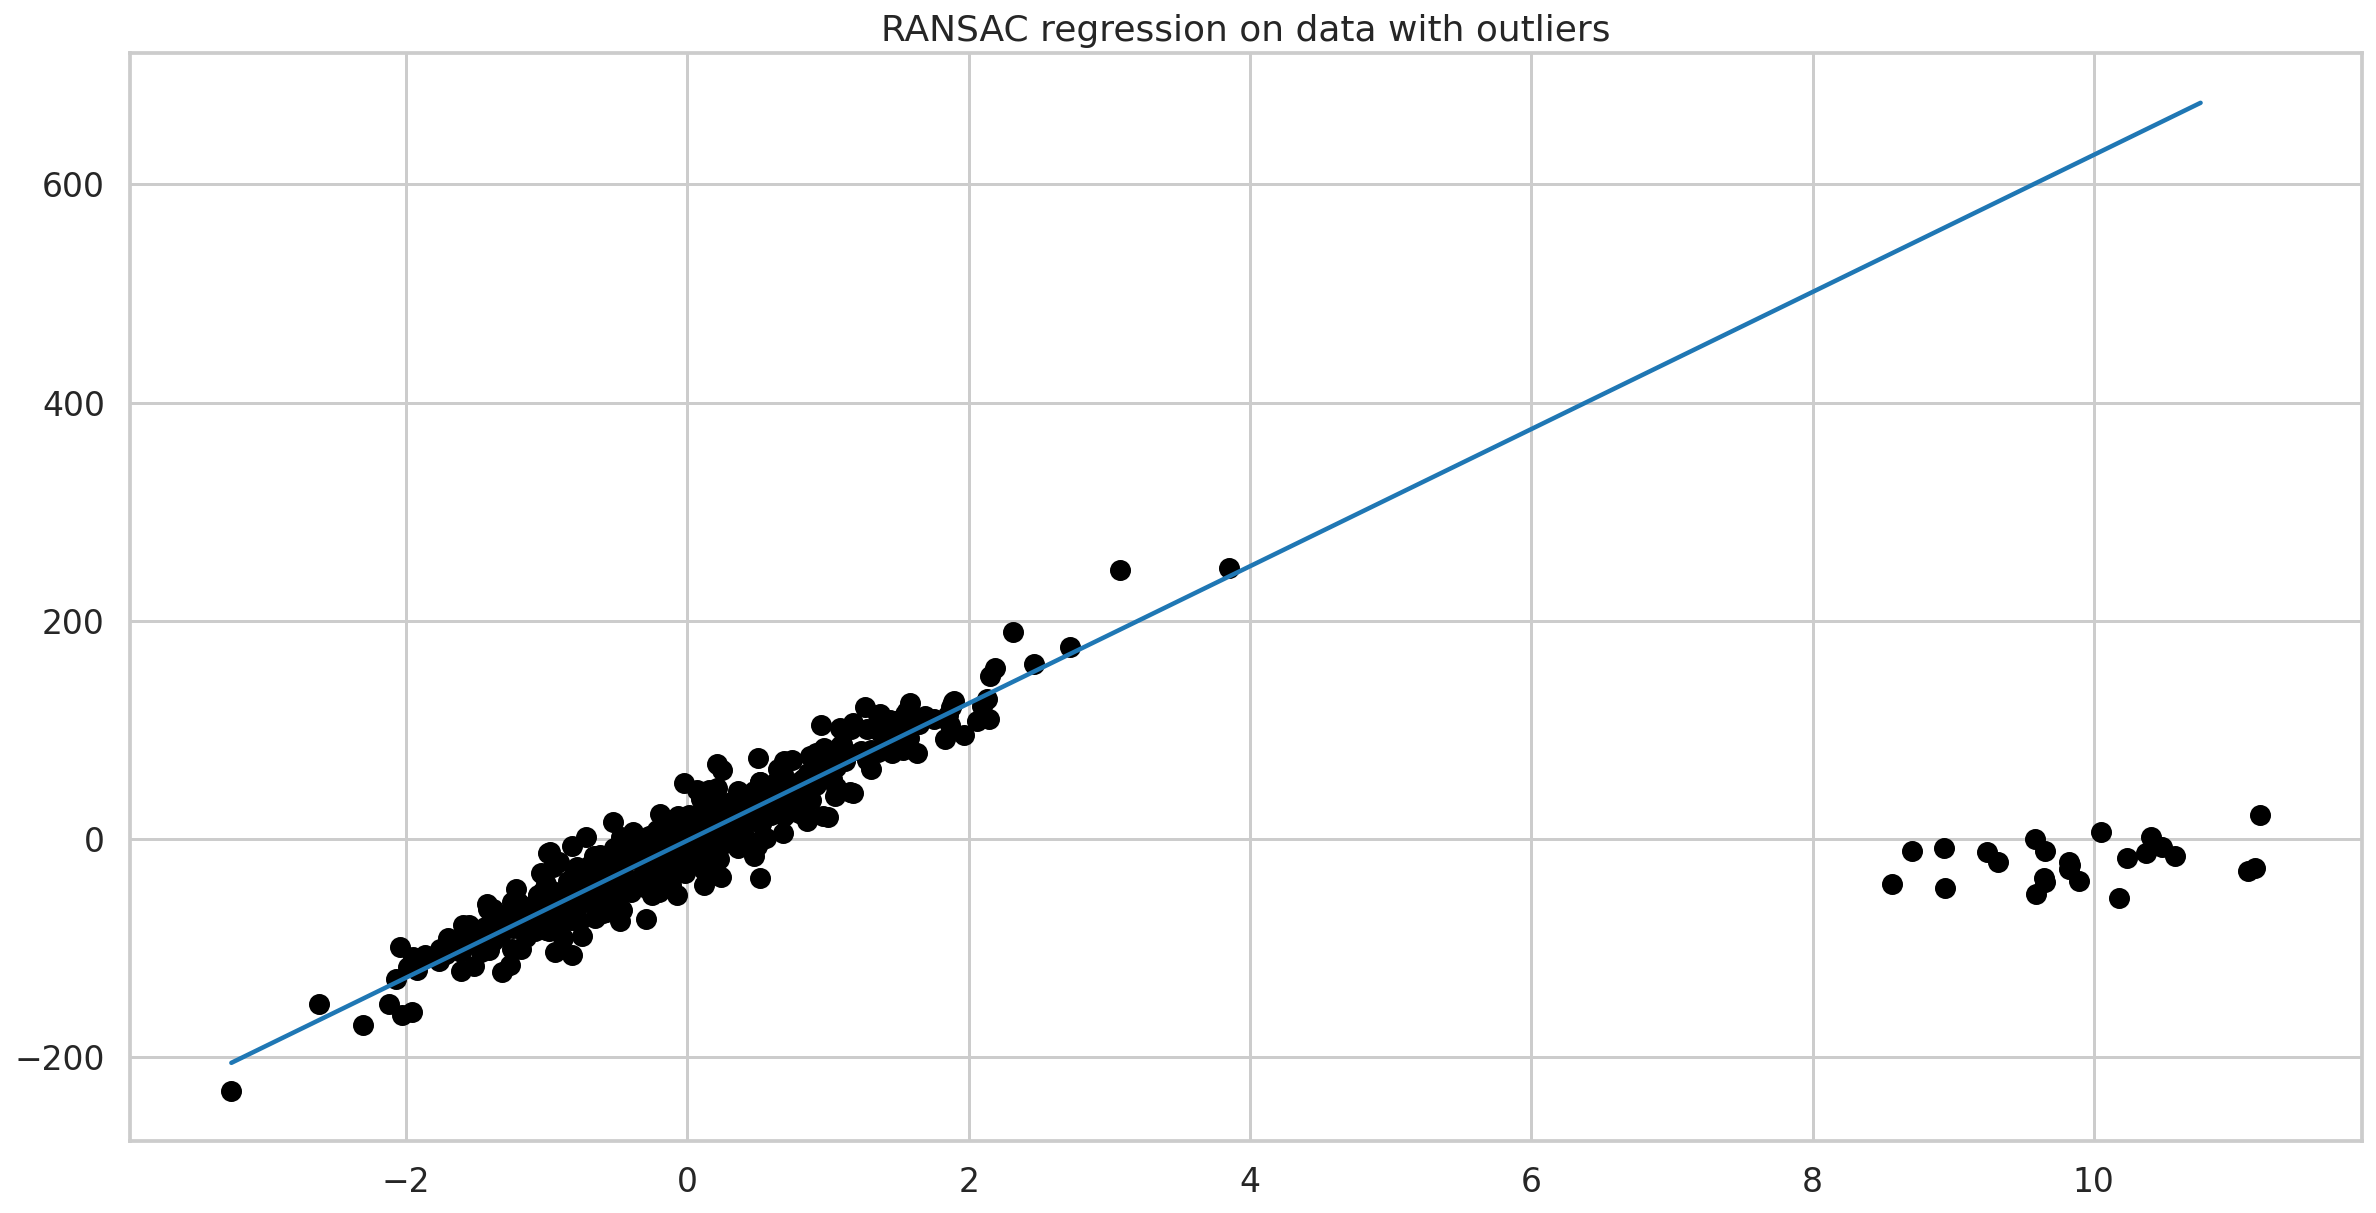

In [22]:
fix, ax = plt.subplots()
fit_df["ransac_regression"].plot(ax=ax)
plt.scatter(X, y, c="k")
plt.title("RANSAC regression on data with outliers");

In [23]:
inlier_mask = ransac.inlier_mask_
outlier_mask = ~inlier_mask
print(f"Total outliers: {sum(outlier_mask)}")
print(f"Outliers we have added ourselves: {sum(outlier_mask[:N_OUTLIERS])} / {N_OUTLIERS}")

Total outliers: 51
Outliers we have added ourselves: 25 / 25


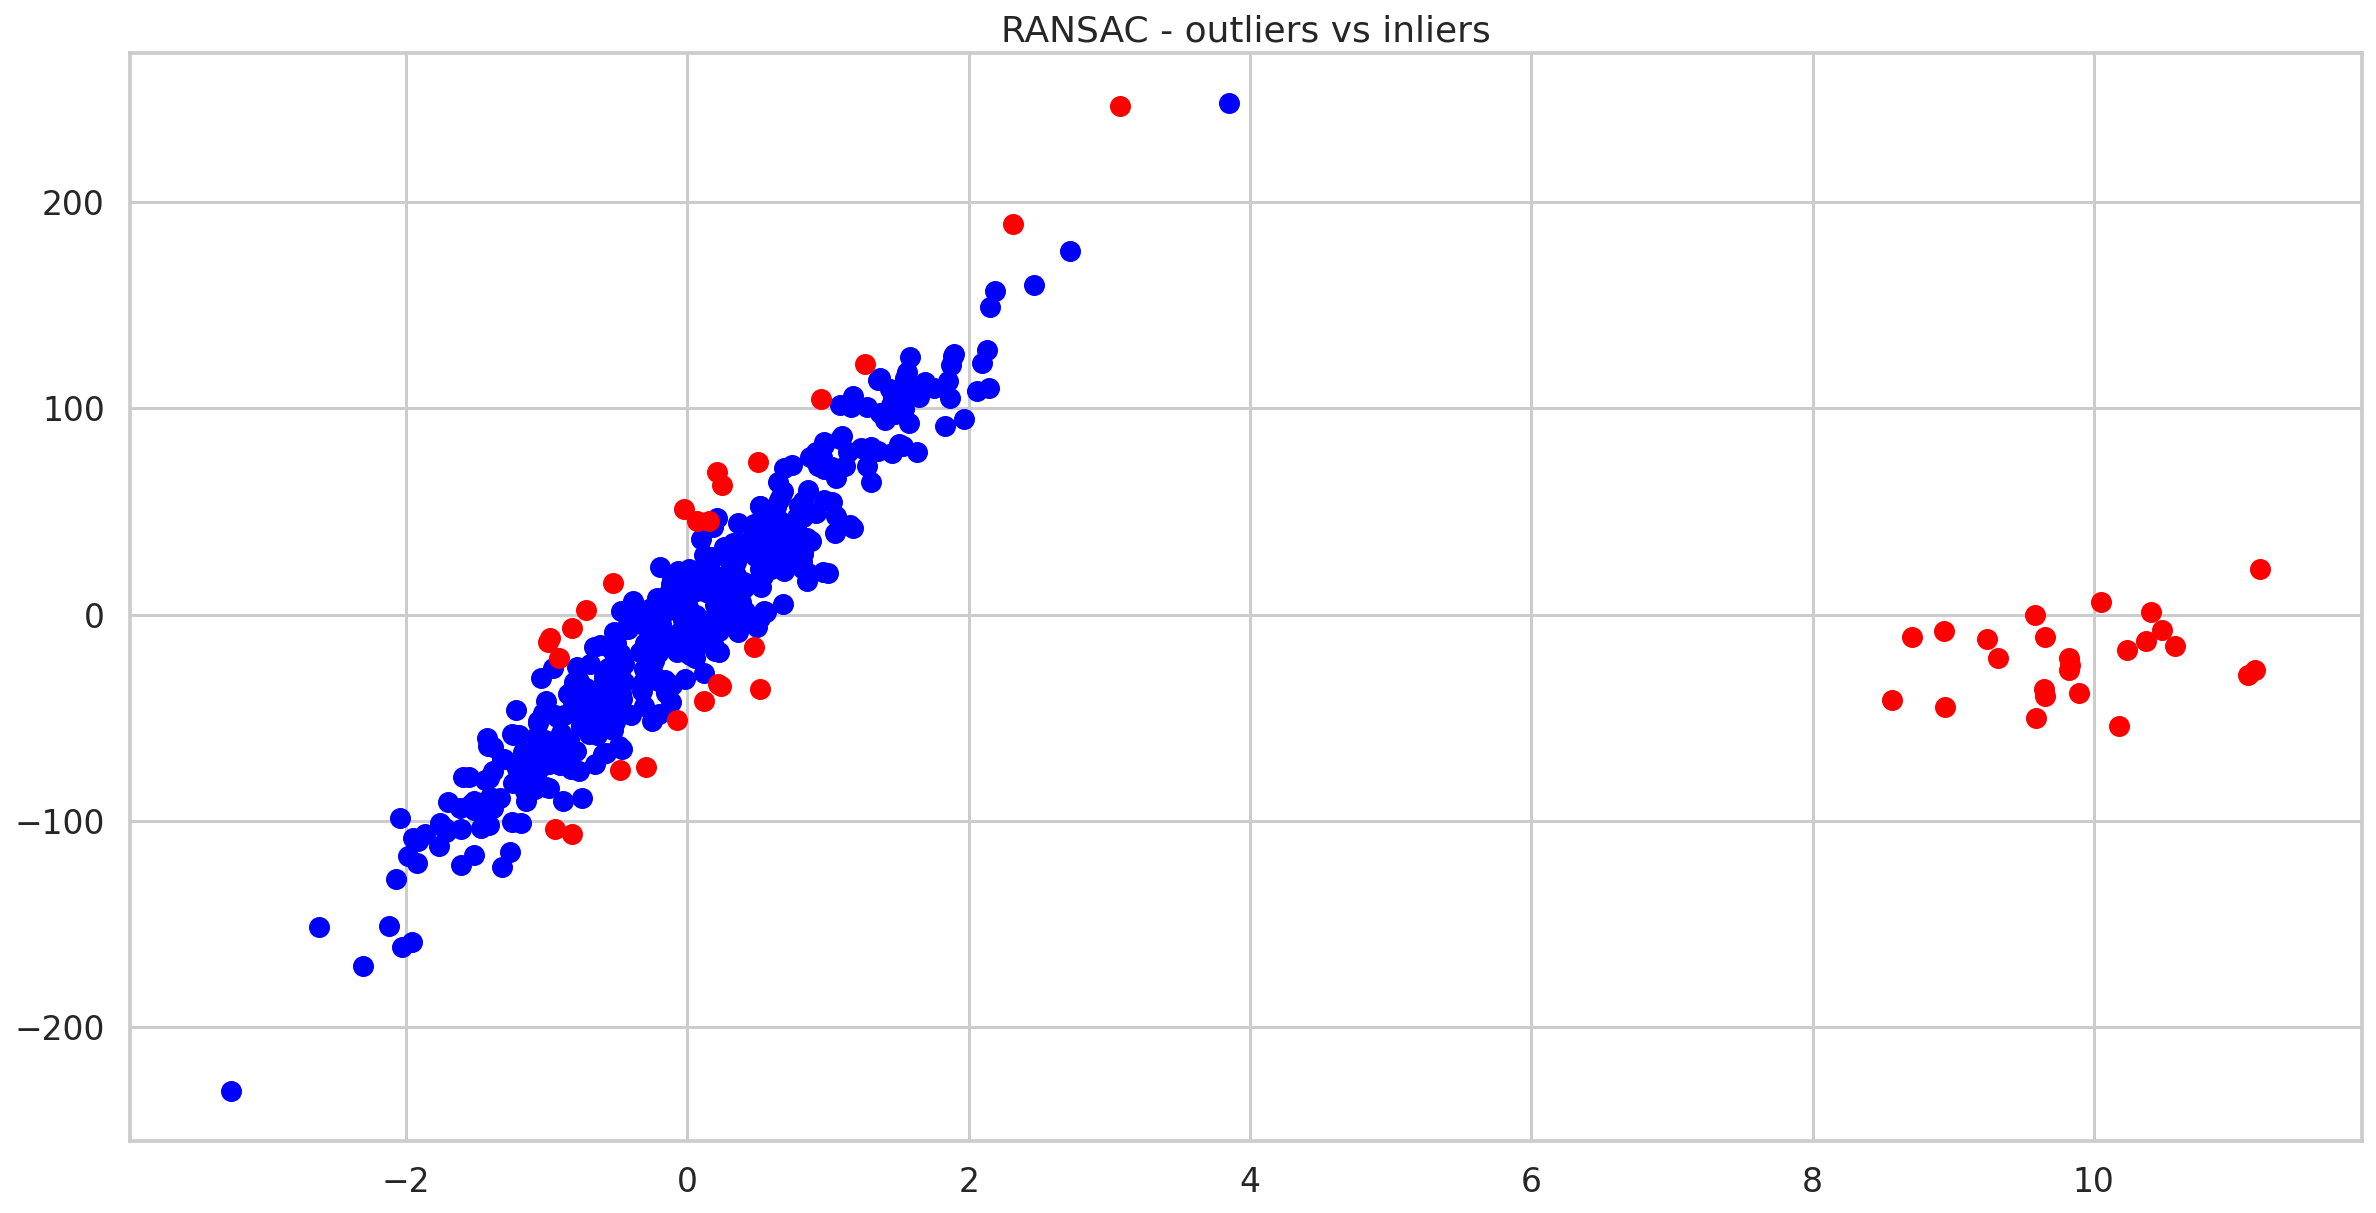

In [24]:
plt.scatter(X[inlier_mask], y[inlier_mask], color="blue", label="Inliers")
plt.scatter(X[outlier_mask], y[outlier_mask], color="red", label="Outliers")
plt.title("RANSAC - outliers vs inliers");

## Theil-Sen

In [25]:
theilsen = TheilSenRegressor(random_state=42).fit(X, y)
fit_df["theilsen_regression"] = theilsen.predict(plotline_X)
coef_list.append(["theilsen_regression", theilsen.coef_[0]])

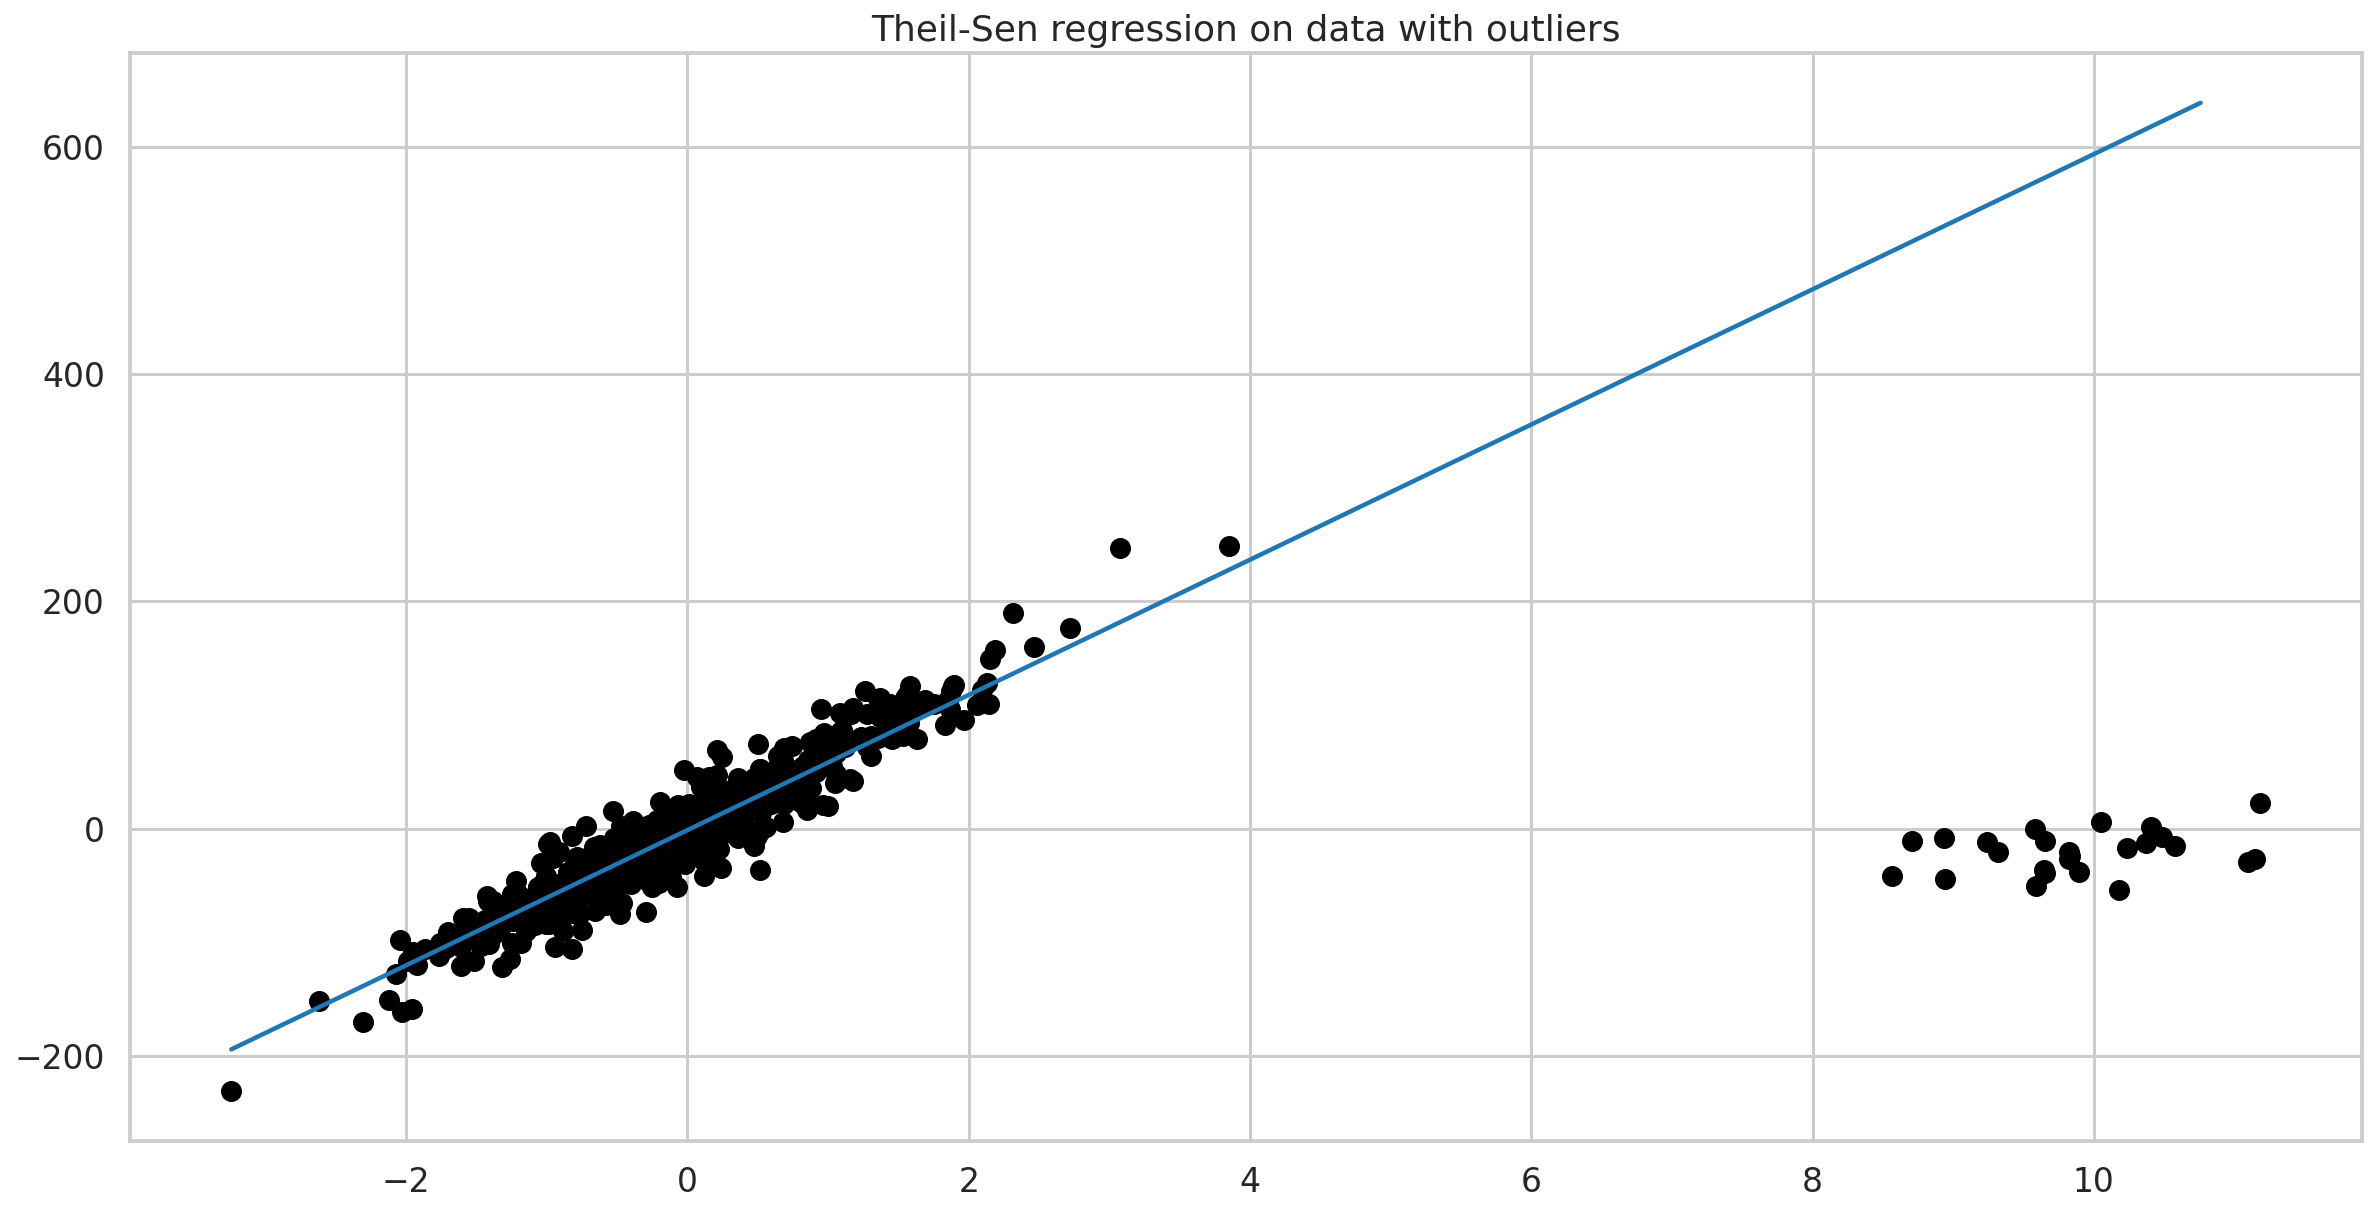

In [26]:
fix, ax = plt.subplots()
fit_df["theilsen_regression"].plot(ax=ax)
plt.scatter(X, y, c="k")
plt.title("Theil-Sen regression on data with outliers");

## Conclusion

In [27]:
pd.DataFrame(coef_list, columns=["model", "coef"]).round(2)

,model,coef
0,original_coef,64.59
1,linear_regression,8.77
2,huber_regression,37.52
3,ransac_regression,62.85
4,theilsen_regression,59.49


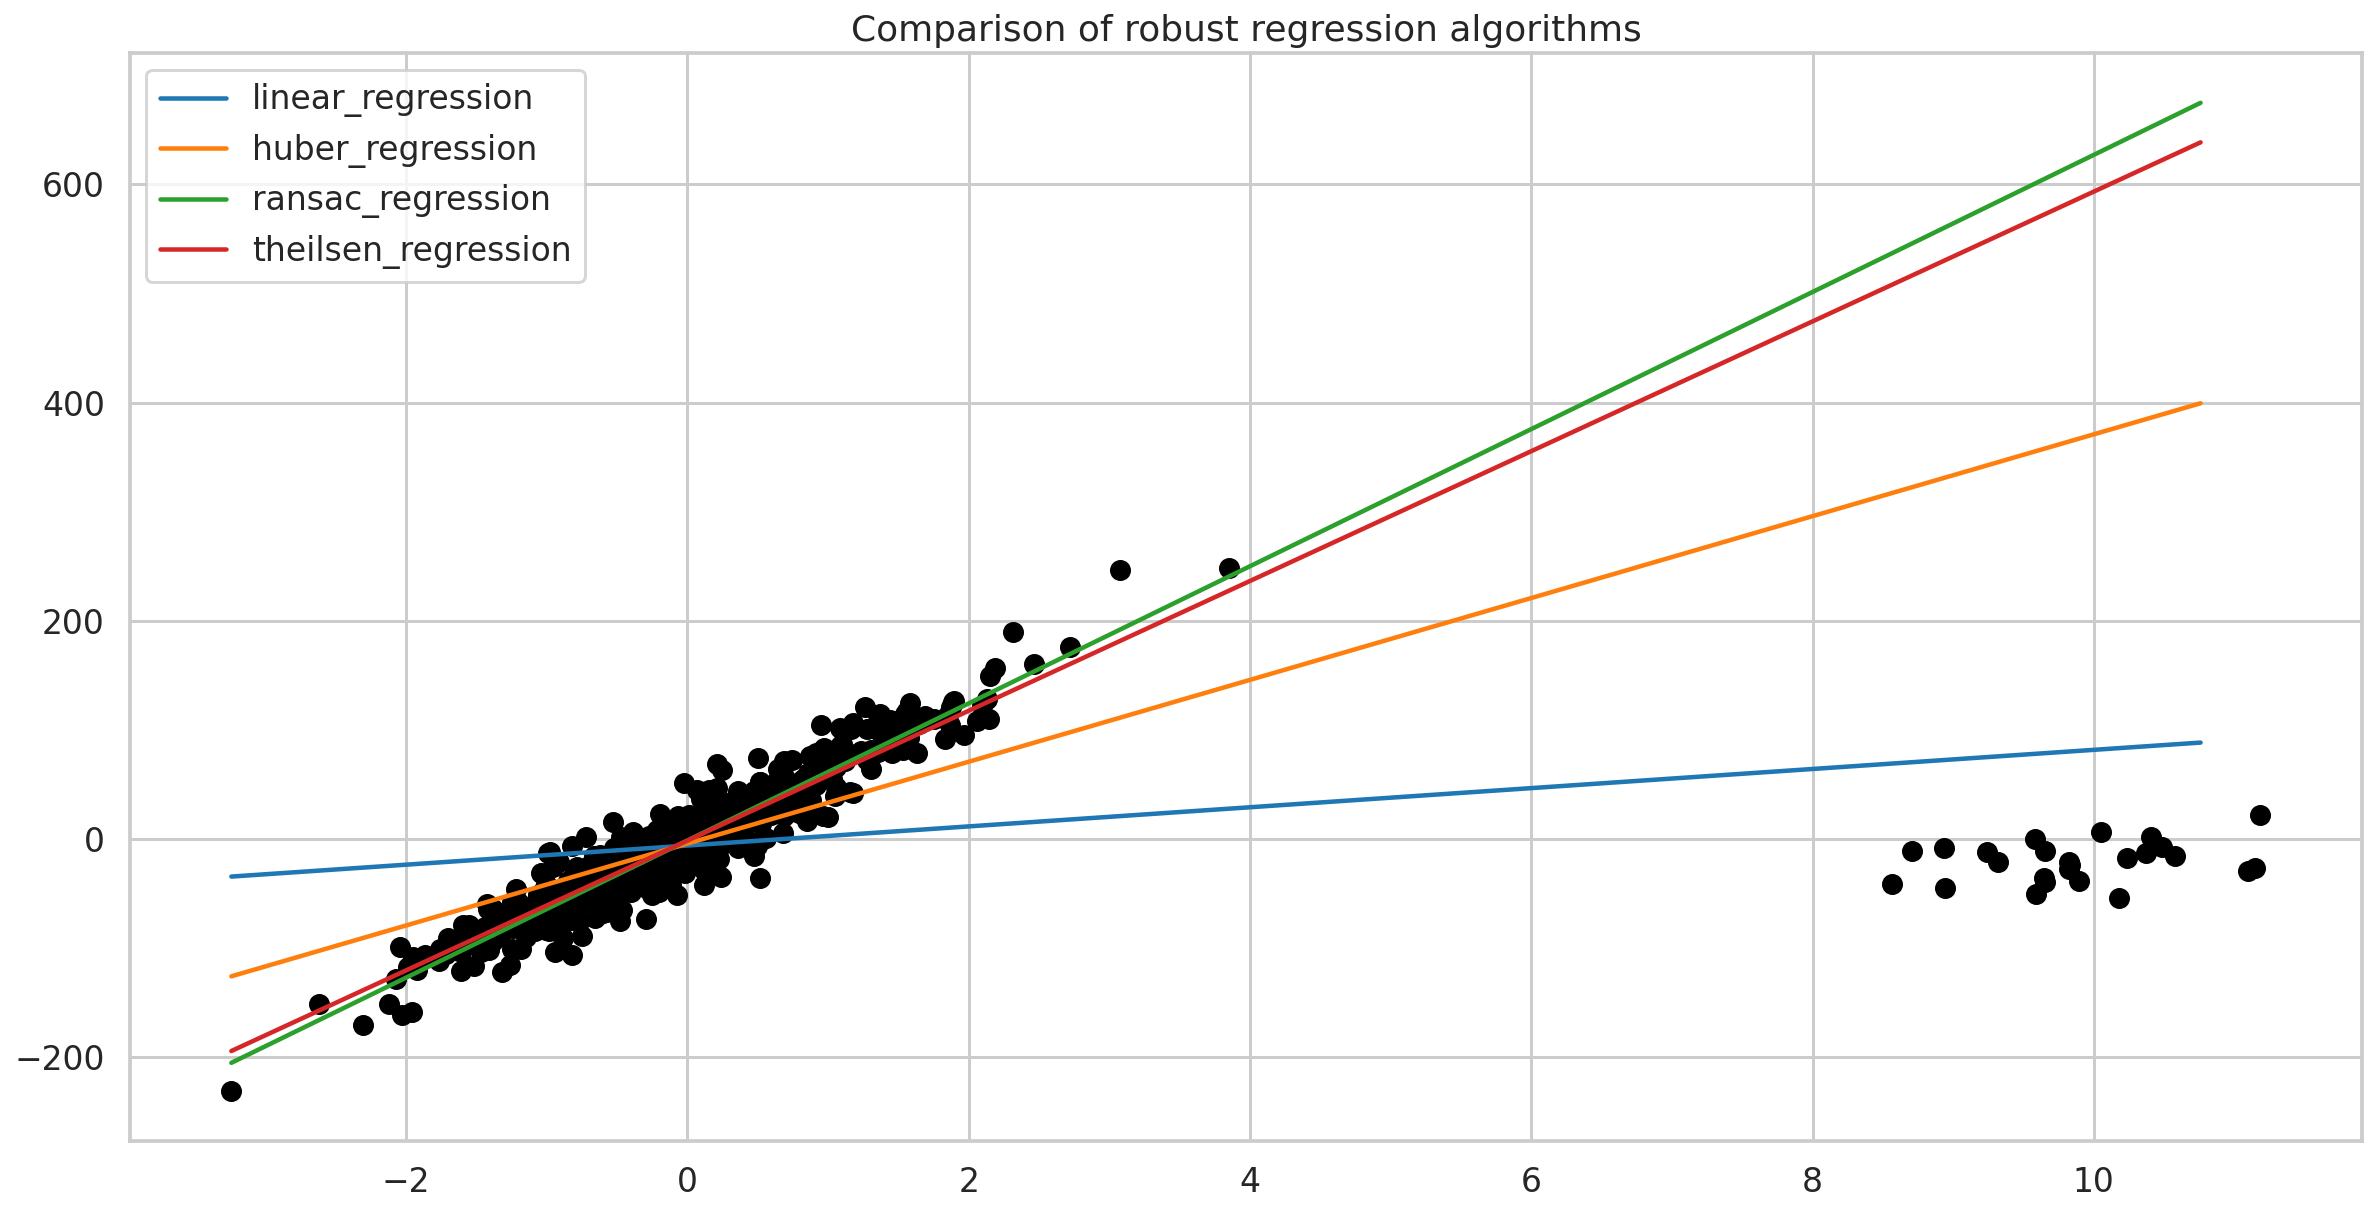

In [28]:
fix, ax = plt.subplots()
fit_df.plot(ax=ax)
plt.scatter(X, y, c="k")
plt.title("Comparison of robust regression algorithms");